In the last part, we tried to classify our images of dogs according to their breeds by building a neural network from scratch: the model was too simple for the task.

In this part, we are going to classify our images by using transfer learning from a pretrained network. Transfer learning is a technique that consists of using a neural network that was already trained on similar task that we want to tackle.

Here, we are going to focus on training and fine tuning the model not on the preprocessing step.

**References:**

* [Transfer learning and fine-tuning](https://www.tensorflow.org/guide/keras/transfer_learning#setup) guide from tensorflow.
* [Transfer learning and fine-tuning](https://www.tensorflow.org/tutorials/images/transfer_learning#data_preprocessing) tutorial from tensorflow.
* [Working with preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers#preprocessing_data_before_the_model_or_inside_the_model) tutorial from tensorflow.
* Chapter14: Deep computer vision using convolutional neural networks from the book hands on machine learning.
* [This](https://github.com/Djinny/Formation-Data-Scientist/blob/master/Reconnaissance%20d'image%20sur%20120%20classes/%C3%89tat%20de%20l'Art%20-%20Deep%20Learning.ipynb) notebook.

# Import libraries

In [1]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Model

DOWNLOAD_ROOT = "http://vision.stanford.edu/aditya86/ImageNetDogs/"
FILENAME = "images.tar"
filepath = keras.utils.get_file(FILENAME, DOWNLOAD_ROOT + FILENAME, extract=True)
data_dir = Path(filepath).parent / "Images"
data_dir

WindowsPath('C:/Users/Tharun/.keras/datasets/Images')

In [2]:
class_names = os.listdir(data_dir)
n_classes = len(os.listdir(data_dir))

n_images = 0
for i in range(n_classes):
    n_images += len(os.listdir(data_dir / class_names[i]))
print("Number of images: ", n_images)
print("Number of classes: ", n_classes)

Number of images:  20580
Number of classes:  120


# Lets observe the Data

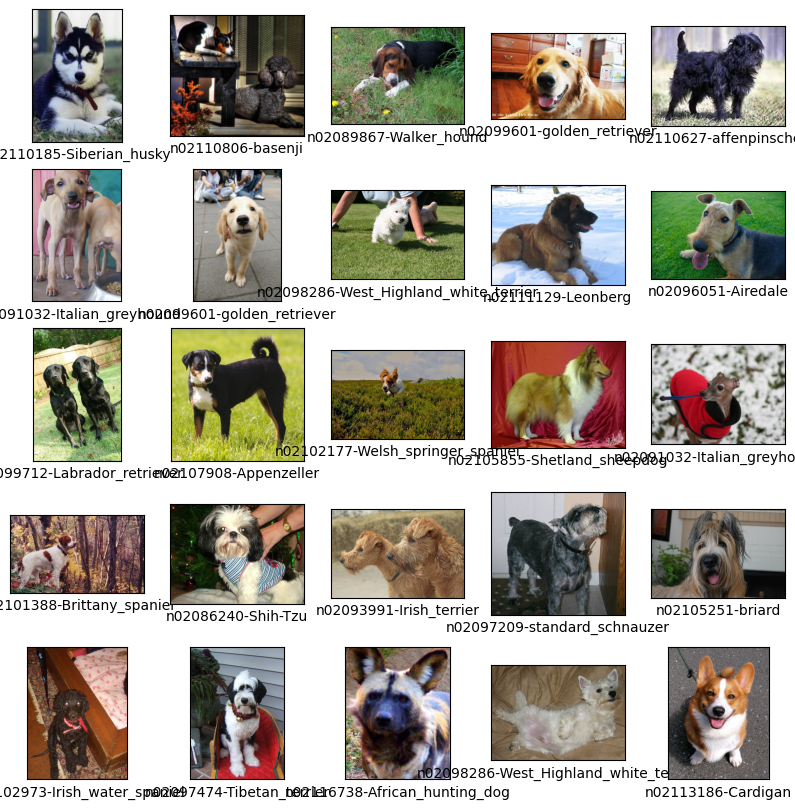

In [18]:
import random

plt.figure(figsize=(10, 10))
for i in range(25):
    class_name = random.choice(class_names)
    file_name = random.choice(os.listdir(data_dir / class_name))
    image = plt.imread(data_dir / class_name / file_name)
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image)
    plt.xlabel(class_name)
plt.show()


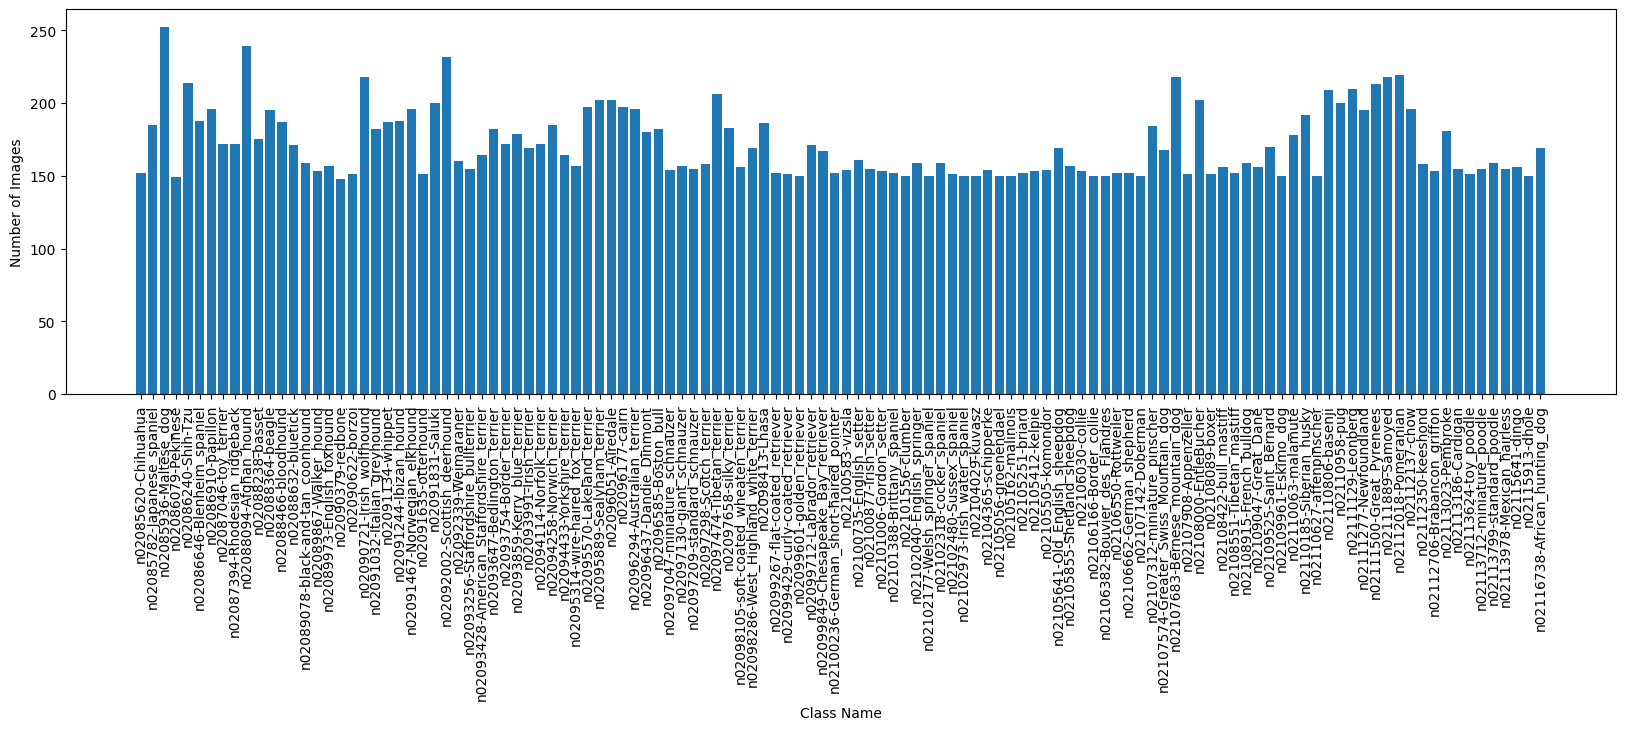

In [19]:
image_counts = [len(os.listdir(data_dir / class_name)) for class_name in class_names]
plt.figure(figsize=(20, 5))
plt.bar(class_names, image_counts)
plt.xticks(rotation=90)
plt.xlabel("Class Name")
plt.ylabel("Number of Images")
plt.show()


# Load using tf.data

In [3]:
import os

def filepaths(data_dir, test_ratio=0.2, validation_ratio=0.2):
    class_names = os.listdir(data_dir)
    n_classes = len(class_names)

    test_ratio = test_ratio
    validation_ratio = validation_ratio

    train_filepaths = []
    valid_filepaths = []
    test_filepaths = []

    for i in range(n_classes):
        img_per_dog = os.listdir(os.path.join(data_dir, class_names[i]))
        img_per_dog = np.array([os.path.join(class_names[i], s) for s in img_per_dog])
        
        total_size = len(img_per_dog)
        test_size = int(total_size * test_ratio)
        validation_size = int(total_size * validation_ratio)
        train_size = total_size - test_size - validation_size

        rnd_indices = np.random.permutation(total_size)

        train_filepaths.append(img_per_dog[rnd_indices[:train_size]])
        valid_filepaths.append(img_per_dog[rnd_indices[train_size:-test_size]])
        test_filepaths.append(img_per_dog[rnd_indices[-test_size:]])

    train_filepaths = np.array([os.path.join(data_dir, s) for s in np.hstack(train_filepaths)])
    valid_filepaths = np.array([os.path.join(data_dir, s) for s in np.hstack(valid_filepaths)])
    test_filepaths = np.array([os.path.join(data_dir, s) for s in np.hstack(test_filepaths)])

    return (train_filepaths, valid_filepaths, test_filepaths)

(train_filepaths, valid_filepaths, test_filepaths) = filepaths(data_dir)
train_filepaths.shape, valid_filepaths.shape, test_filepaths.shape


((12436,), (4072,), (4072,))

In [4]:

norm_layer = layers.experimental.preprocessing.Rescaling(1./255)

def get_label(file_path):
    """Takes the label from the file path"""
    parts = tf.strings.split(file_path, os.path.sep)
    one_hot = parts[-2] == class_names
    one_hot = tf.cast(one_hot, tf.float32)
    return tf.argmax(one_hot)

def preprocess_mobilenet(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    final_img = keras.applications.mobilenet_v2.preprocess_input(img)
    return img, label

def create_dataset(filepaths, preprocess, batch_size=32, buffer_size=1000):
    ds = tf.data.Dataset.list_files(filepaths, seed=42)
    ds = ds.map(preprocess, num_parallel_calls=5)
    ds = ds.map(lambda x, y: (norm_layer(x), y), num_parallel_calls=5)
    ds = ds.shuffle(buffer_size, seed=42)
    ds = ds.batch(batch_size)
    return ds.prefetch(1)

# Model 1: MobilNetv2

Create the datasets:

In [5]:
train_set_mobilenet = create_dataset(train_filepaths, preprocess_mobilenet) 
valid_set_mobilenet = create_dataset(valid_filepaths, preprocess_mobilenet)
test_set_mobilenet = create_dataset(test_filepaths, preprocess_mobilenet)

# Data augmentation and Dropout

In [6]:
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomContrast(0.2),
    layers.experimental.preprocessing.RandomFlip('horizontal'),
])

Let's visualize an image after applying the above random transformations:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


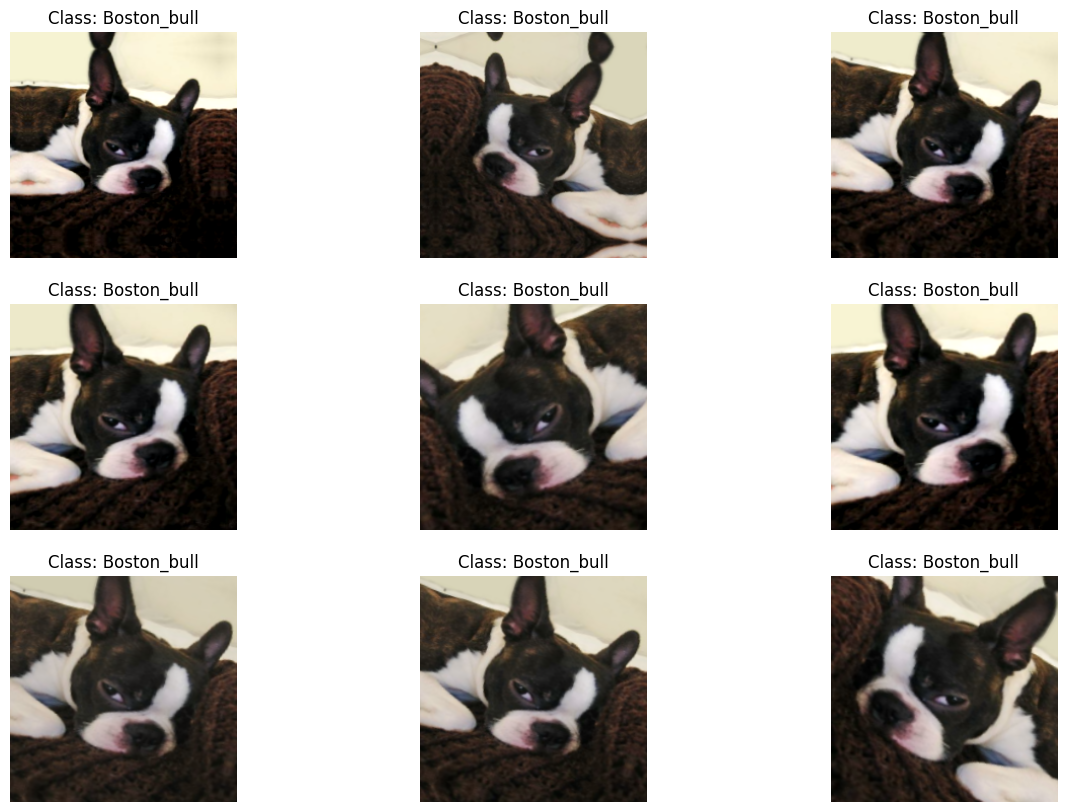

In [7]:
plt.figure(figsize=(15, 10))
for images, labels in train_set_mobilenet.take(1):
    for i in range(9):
        augmented_image = data_augmentation(images)
        plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_image[0])
        plt.title("Class: " + class_names[labels[0]][10:])
        plt.axis("off")

In [8]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

base_model_mobilenet = tf.keras.applications.MobileNetV2(
                                    weights="imagenet", include_top=False)

# Create a new model on top
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model_mobilenet(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(n_classes, activation="softmax")(x)
mobilenet_model = Model(inputs=inputs, outputs=outputs)

# Freeze the weights of the base model
for layer in base_model_mobilenet.layers:
    layer.trainable = False

# Compile the model and start training
mobilenet_model.compile(optimizer=keras.optimizers.Adam(lr=1e-4),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])
mobilenet_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, None, None, 1280)  2257984  
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0     

In [9]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=3, # Number of epochs with no improvement after which training will be stopped.
    restore_best_weights=True, # Whether to restore model weights from the epoch with the best value of the monitored quantity.
)
from tensorflow.keras.callbacks import TensorBoard
import datetime

# Define the log directory for TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Create a TensorBoard callback
tensorboard_cb = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [10]:
epochs=40
history_mobilenet = mobilenet_model.fit(train_set_mobilenet, epochs=epochs, 
                                        validation_data=valid_set_mobilenet, 
                                        callbacks=[early_stopping_cb, tensorboard_cb])
# Let's save the model before we do fine-tuning
mobilenet_model.save("mobilenet_without_fine_tuning.h5")

Epoch 1/40
389/389 [==============================] - 508s 1s/step - loss: 2.2753 - accuracy: 0.4285 - val_loss: 0.9764 - val_accuracy: 0.7085
Epoch 2/40
389/389 [==============================] - 502s 1s/step - loss: 1.4447 - accuracy: 0.5891 - val_loss: 0.8435 - val_accuracy: 0.7429
Epoch 3/40
389/389 [==============================] - 459s 1s/step - loss: 1.2713 - accuracy: 0.6265 - val_loss: 0.8508 - val_accuracy: 0.7360
Epoch 4/40
389/389 [==============================] - 446s 1s/step - loss: 1.2072 - accuracy: 0.6469 - val_loss: 0.8450 - val_accuracy: 0.7468
Epoch 5/40
389/389 [==============================] - 466s 1s/step - loss: 1.1392 - accuracy: 0.6632 - val_loss: 0.8138 - val_accuracy: 0.7446
Epoch 6/40
389/389 [==============================] - 467s 1s/step - loss: 1.0889 - accuracy: 0.6781 - val_loss: 0.8248 - val_accuracy: 0.7502
Epoch 7/40
389/389 [==============================] - 461s 1s/step - loss: 1.0301 - accuracy: 0.6954 - val_loss: 0.8295 - val_accuracy: 0.7448

# Learning curves

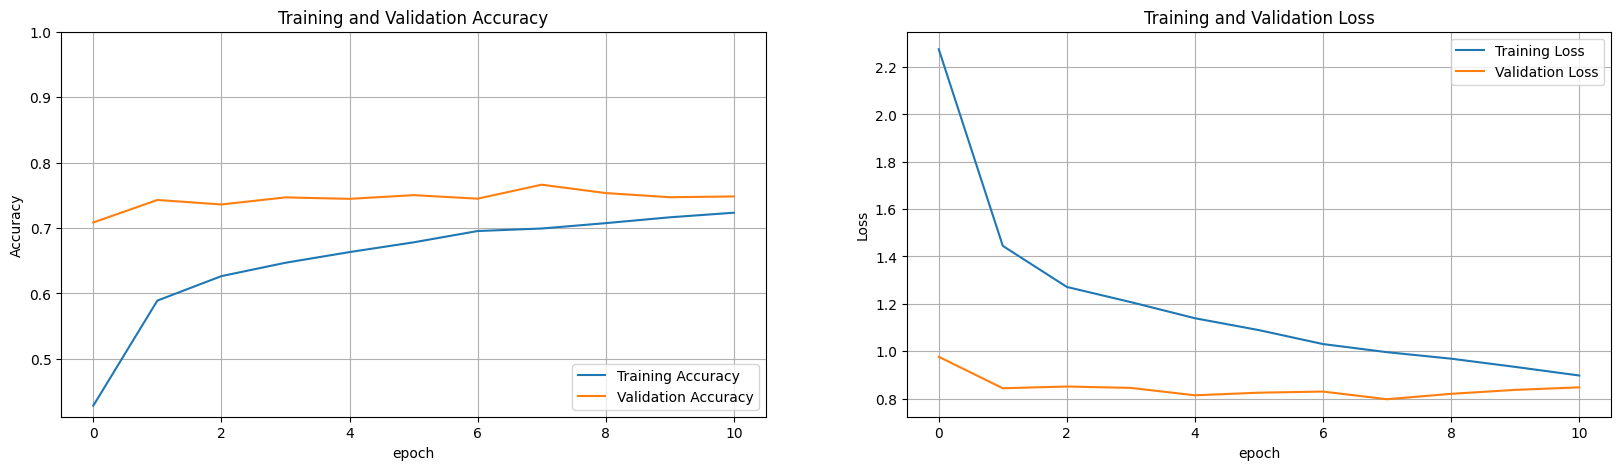

In [16]:

def plot_learning_curves(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.plot(accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')
    plt.xlabel('epoch')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.grid(True)
    plt.show()
plot_learning_curves(history_mobilenet)

In [17]:
# Evaluate the final model on the test set
final_model = keras.models.load_model("mobilenet_without_fine_tuning.h5")
loss, accuracy = final_model.evaluate(test_set_mobilenet)
print('Test accuracy :', np.round((accuracy * 100), 2), '%')

128/128 [==============================] - 101s 767ms/step - loss: 0.8125 - accuracy: 0.7566
Test accuracy : 75.66 %


In [ ]:
import tensorflow.keras.preprocessing.image as image
from tensorflow.keras.applications.vgg19 import preprocess_input

# Define image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Preprocess the image data for the VGG19 model
train_generator = image.ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    validation_split=0.2
)

# Create image generators for the training, validation, and test sets
train_images = train_generator.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    subset="training"
)

valid_images = train_generator.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
    subset="validation"
)

test_images = image.ImageDataGenerator(
    preprocessing_function=preprocess_input
).flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
    subset="validation"
)

# Load the VGG19 model without the classification layer
vgg19_model = tf.keras.applications.VGG19(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet"
)

# Freeze the layers in the VGG19 model
for layer in vgg19_model.layers:
    layer.trainable = False

# Add a new classification layer on top of the frozen VGG19 model
inputs = keras.Input(shape=IMG_SIZE + (3,))
x = vgg19_model(inputs, training=False)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(n_classes, activation="softmax")(x)

# Compile the model
model = keras.Model(inputs, outputs)
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Train the model
history = model.fit(
    train_images,
    validation_data=valid_images,
    epochs=10,
    batch_size=BATCH_SIZE
)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_images, verbose=2)
print("Test accuracy:", test_acc)


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

# Set hyperparameters
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

# Load the data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_images = train_datagen.flow_from_directory(
    "train/",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

valid_images = valid_datagen.flow_from_directory(
    "valid/",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_images = test_datagen.flow_from_directory(
    "test/",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

# Load the pre-trained VGG19 model
vgg19 = VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

# Freeze the layers in the pre-trained model
for layer in vgg19.layers:
    layer.trainable = False

# Add a custom output layer to the pre-trained model
x = Flatten()(vgg19.output)
x = Dense(120, activation="softmax")(x)
model = Model(inputs=vgg19.input, outputs=x)

# Compile the model
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Train the model
history = model.fit(
    train_images,
    validation_data=valid_images,
    epochs=10,
    batch_size=BATCH_SIZE
)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_images, verbose=2)
print("Test accuracy:", test_acc)